## PROJECT 1 - NYC Taxi Data Analysis

This notebook demonstrates how to analyze a sample of NYC Taxi trip data using PySpark and Shapely.  
We will:

1. Load the CSV data
2. Filter out outliers (invalid or overly long trips)  
3. Enrich the data with borough names using GeoJSON and Shapely  
4. Compute several queries:
   - **Query 1**: Taxi utilization  
   - **Query 2**: Average time to find the next fare (per destination borough)  
   - **Query 3**: Number of trips starting and ending in the same borough  
   - **Query 4**: Number of trips that start in one borough and end in another  


## 1. Imports and Spark Session

In [77]:
import json
from shapely.geometry import shape, Point

# PySpark imports
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

import matplotlib.pyplot as plt
import seaborn as sns


In [47]:
spark = SparkSession.builder \
    .appName("NYCTaxiAnalysis") \
    .getOrCreate()

# Example schema for the sample CSV (adjust to match your file)
schema = StructType([
    StructField("medallion", StringType(), True),
    StructField("hack_license", StringType(), True),
    StructField("vendor_id", StringType(), True),
    StructField("rate_code", StringType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("pickup_datetime", StringType(), True),
    StructField("dropoff_datetime", StringType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_time_in_secs", IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_latitude", DoubleType(), True)
])


In [48]:
csv_path = "sample/nyc_taxi_sample.csv"

In [49]:
df = spark.read.csv(
    csv_path,
    header=True,
    inferSchema=True
)

df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



In [50]:
df.show(5)

+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N| 01-01-13 15:11|  01-01-13 15:18|              4|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|        1|                 N| 06-01-13 00:18|  06-01-13 00:22|              1|      -74.006683|      40.731781|       -73.994499|        40.75066|


## 2. Data Preprocessing and Cleaning
- Convert pickup/dropoff times to timestamps.
- Compute a duration in seconds.
- Filter out negative or extremely long durations (> 4 hours).

In [51]:
# Convert to unix timestamps (in seconds)**

df = df.withColumn(
    "pickup_ts",
    F.unix_timestamp("pickup_datetime", "MM-dd-yy HH:mm")
)

df = df.withColumn(
    "dropoff_ts",
    F.unix_timestamp("dropoff_datetime", "MM-dd-yy HH:mm")
)

In [52]:
df.select("pickup_datetime", "pickup_ts").show(5, truncate=False)


+---------------+----------+
|pickup_datetime|pickup_ts |
+---------------+----------+
|01-01-13 15:11 |1357045860|
|06-01-13 00:18 |1370035080|
|05-01-13 18:49 |1367423340|
|07-01-13 23:54 |1372712040|
|07-01-13 23:25 |1372710300|
+---------------+----------+
only showing top 5 rows



In [53]:
df = df.withColumn("Duration", F.col("dropoff_ts") - F.col("pickup_ts"))

In [54]:
df = df.filter(
    (F.col("Duration") >= 0) &
    (F.col("Duration") <= 14400)  # 4 hours = 14400 seconds
)

In [55]:
df.show(5)

+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+----------+----------+--------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude| pickup_ts|dropoff_ts|Duration|
+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+----------+----------+--------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N| 01-01-13 15:11|  01-01-13 15:18|              4|      -73.978165|      40.757977|       -73.989838|       40.751171|1357045860|1357046280|     420|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|        1|             

## 3. Load GeoJSON and Prepare Borough Polygons
- We will parse the GeoJSON file and create Shapely `Polygon` objects.
- Then we'll sort by `(borough_code, -area)` for faster lookups.

In [59]:
geojson_path = "sample/nyc_boroughs.geojson"

with open(geojson_path, "r") as f:
    geojson_data = json.load(f)

features = geojson_data["features"]

In [60]:
borough_polygons = []
for feat in features:
    props = feat["properties"]
    borough_code = props["boroughCode"]
    borough_name = props["borough"]
    
    geom = shape(feat["geometry"])  # Shapely geometry (Polygon or MultiPolygon)
    area = geom.area
    
    borough_polygons.append((borough_code, borough_name, geom, area))

In [61]:

# Sort by (borough_code ascending, area descending)
borough_polygons.sort(key=lambda x: (x[0], -x[3]))

In [64]:
borough_polygons

[(1,
  'Manhattan',
  <POLYGON ((-73.926 40.878, -73.926 40.877, -73.926 40.877, -73.926 40.877, -...>,
  0.005859077996035753),
 (1,
  'Manhattan',
  <POLYGON ((-73.921 40.801, -73.92 40.799, -73.917 40.798, -73.915 40.797, -7...>,
  0.00023271655856762013),
 (1,
  'Manhattan',
  <POLYGON ((-74.017 40.693, -74.015 40.693, -74.015 40.693, -74.015 40.693, -...>,
  7.6037752599342e-05),
 (1,
  'Manhattan',
  <POLYGON ((-73.942 40.769, -73.943 40.768, -73.949 40.761, -73.952 40.758, -...>,
  6.23157479510608e-05),
 (1,
  'Manhattan',
  <POLYGON ((-73.907 40.876, -73.908 40.873, -73.908 40.873, -73.909 40.872, -...>,
  3.2658591272044954e-05),
 (1,
  'Manhattan',
  <POLYGON ((-74.04 40.701, -74.038 40.699, -74.038 40.699, -74.038 40.698, -7...>,
  1.1828883137677094e-05),
 (1,
  'Manhattan',
  <POLYGON ((-74.044 40.69, -74.044 40.69, -74.043 40.69, -74.043 40.69, -74.0...>,
  6.143638903459381e-06),
 (1,
  'Manhattan',
  <POLYGON ((-73.995 40.703, -73.997 40.701, -73.998 40.702, -73.996 40

In [66]:
# We only need (boroughName, geometry) in the final broadcast
sorted_boroughs = [(b[1], b[2]) for b in borough_polygons]

In [67]:
# Broadcast to Spark workers
broadcast_boroughs = spark.sparkContext.broadcast(sorted_boroughs)

In [68]:
len(sorted_boroughs)

104

## 5. Define a UDF to Find Borough for (Latitude, Longitude)
We'll use Shapely to check which polygon contains the point.

In [69]:
def find_borough(lat, lon, borough_list):
    """
    Given lat, lon, return the borough name if it falls inside a polygon,
    otherwise return 'Unknown'.
    """
    if lat is None or lon is None:
        return None
    point = Point(lon, lat)  # shapely Point uses (x=lon, y=lat)
    
    for borough_name, polygon in borough_list:
        if polygon.contains(point):
            return borough_name
    
    return "Unknown"

def borough_lookup_udf(lat, lon):
    return find_borough(lat, lon, broadcast_boroughs.value)

# Register as a Spark UDF
lookup_udf = F.udf(borough_lookup_udf, StringType())

## 6. Enrich Taxi Data with Borough Names
- Apply the UDF to pickup and dropoff lat/lon.
- Rename the `medallion` column to `taxi_id` (for clarity).

In [71]:
df = df.withColumn("pickup_borough",
                   lookup_udf("pickup_latitude", "pickup_longitude"))
df = df.withColumn("dropoff_borough",
                   lookup_udf("dropoff_latitude", "dropoff_longitude"))

df = df.withColumnRenamed("medallion", "taxi_id")

df.select("taxi_id", "pickup_borough", "dropoff_borough").show(5, truncate=False)

+--------------------------------+--------------+---------------+
|taxi_id                         |pickup_borough|dropoff_borough|
+--------------------------------+--------------+---------------+
|89D227B655E5C82AECF13C3F540D4CF4|Manhattan     |Manhattan      |
|0BD7C8F5BA12B88E0B67BED28BEA73D8|Manhattan     |Manhattan      |
|0BD7C8F5BA12B88E0B67BED28BEA73D8|Manhattan     |Manhattan      |
|DFD2202EE08F7A8DC9A57B02ACB81FE2|Manhattan     |Manhattan      |
|DFD2202EE08F7A8DC9A57B02ACB81FE2|Manhattan     |Manhattan      |
+--------------------------------+--------------+---------------+
only showing top 5 rows



## 7. Queries

### 7.1 Query 1: Utilization per Taxi
Utilization = Total Ride Time / (Total Ride Time + Total Idle Time)

We'll:
1. Partition by `taxi_id`, order by `pickup_ts`.
2. Compute idle time = gap between consecutive trips (if <= 4 hours).
3. Sum up ride time and idle time per taxi.
4. Compute utilization.

In [72]:
# Window partitioned by taxi_id, ordered by pickup_ts
w = Window.partitionBy("taxi_id").orderBy("pickup_ts")

df = df.withColumn("prev_dropoff_ts", F.lag("dropoff_ts").over(w))

# Idle time between consecutive trips (if gap <= 4 hours)
idle_expr = F.when(
    (F.col("pickup_ts") - F.col("prev_dropoff_ts") <= 4 * 3600) &
    (F.col("pickup_ts") - F.col("prev_dropoff_ts") >= 0),
    F.col("pickup_ts") - F.col("prev_dropoff_ts")
).otherwise(F.lit(0))

df = df.withColumn("idle_time", idle_expr)

util_df = df.groupBy("taxi_id").agg(
    F.sum("Duration").alias("total_ride_time"),
    F.sum("idle_time").alias("total_idle_time")
)

util_df = util_df.withColumn(
    "utilization",
    F.col("total_ride_time") / (F.col("total_ride_time") + F.col("total_idle_time"))
)

print("=== Utilization per Taxi ===")
util_df.show(10, truncate=False)

=== Utilization per Taxi ===


+--------------------------------+---------------+---------------+-------------------+
|taxi_id                         |total_ride_time|total_idle_time|utilization        |
+--------------------------------+---------------+---------------+-------------------+
|01C34EB474D1D99C1F26E12FCF08B9F6|420            |0              |1.0                |
|02BFD1B64C2C80B433D3A282C828912B|480            |0              |1.0                |
|0428E3DD09EA5A63D85509C7CA8C0199|300            |0              |1.0                |
|08099C118772D01BBA1C3F486BD8AF1E|600            |0              |1.0                |
|09C6A58617D39C6AF257965FE1EADADD|180            |0              |1.0                |
|0A3EF18FFD7FA5327C66C6B1CE068F3A|1380           |0              |1.0                |
|0B57B9633A2FECD3D3B1944AFC7471CF|3300           |12300          |0.21153846153846154|
|0BD7C8F5BA12B88E0B67BED28BEA73D8|540            |0              |1.0                |
|0C3D03822EC2B0DAABC565EF330580E9|120      

### 7.2 Query 2: Average Time to Find Next Fare per Destination Borough
1. Again use a window by `taxi_id` to access the **next** trip's pickup time.  
2. Compute `time_to_next_fare = next_pickup_ts - dropoff_ts` (if <= 4 hours).  
3. Group by `dropoff_borough` to get the average.

In [73]:
w2 = Window.partitionBy("taxi_id").orderBy("pickup_ts")

df = df.withColumn("next_pickup_ts", F.lead("pickup_ts").over(w2))

df = df.withColumn(
    "time_to_next_fare",
    F.when(
        (F.col("next_pickup_ts") - F.col("dropoff_ts") <= 4*3600) &
        (F.col("next_pickup_ts") - F.col("dropoff_ts") >= 0),
        F.col("next_pickup_ts") - F.col("dropoff_ts")
    ).otherwise(F.lit(None))
)

wait_time_df = df.groupBy("dropoff_borough") \
    .agg(F.avg("time_to_next_fare").alias("avg_time_to_next_fare"))

print("=== Average Time to Find Next Fare per Destination Borough ===")
wait_time_df.show(10, truncate=False)

=== Average Time to Find Next Fare per Destination Borough ===
+---------------+---------------------+
|dropoff_borough|avg_time_to_next_fare|
+---------------+---------------------+
|Queens         |7290.0               |
|Unknown        |8720.0               |
|Brooklyn       |3420.0               |
|Manhattan      |4037.3333333333335   |
+---------------+---------------------+



### 7.3 Query 3: Number of Trips that Started and Ended in the Same Borough

In [74]:
same_borough_count = df.filter(
    F.col("pickup_borough") == F.col("dropoff_borough")
).count()

print("Number of trips that start and end in the same borough:", same_borough_count)

Number of trips that start and end in the same borough: 201


### 7.4 Query 4: Number of Trips that Started in One Borough and Ended in Another

In [76]:
diff_borough_count = df.filter(
    F.col("pickup_borough") != F.col("dropoff_borough")
).count()

print("Number of trips that start in one borough and end in another:", diff_borough_count)

Number of trips that start in one borough and end in another: 40


## 8. Visualizations

We’ll demonstrate a bar chart of pickup counts by borough

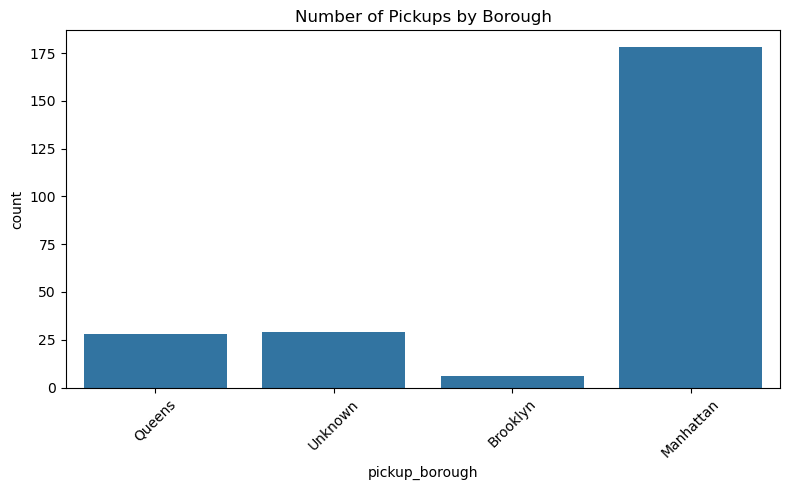

In [78]:
# 8.1. Bar Chart: Number of Pickups by Borough
pickup_counts_spark = df.groupBy("pickup_borough").count()

# Convert to Pandas (collecting small aggregated data is typically fine)
pickup_counts_pdf = pickup_counts_spark.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=pickup_counts_pdf, x="pickup_borough", y="count")
plt.title("Number of Pickups by Borough")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Conclusion

We have:
- Loaded and cleansed NYC Taxi data
- Enriched it with borough information (pickup and dropoff)
- Computed key metrics:
  - Utilization per taxi
  - Average wait time for next fare
  - Same vs. different borough trip counts
- Created basic visualizations (bar chart, histogram)

This framework can be extended for deeper analyses or more sophisticated visualizations.
